In [1]:
#install.packages("ggrepel") #used to add labels to points on graph
library(tidyverse)
sapply(c("dplyr", "ggplot2","ggrepel","reshape2","ggalt"), library, character.only = T, logical.return = T, 
       quietly = T)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



dplyr  ggplot2  ggrepel reshape2    ggalt 
    TRUE     TRUE     TRUE    FALSE    FALSE

# Should I Stay or Should I Throw?
### Overview
Quarterback is arguably the most important position in all of football. The quarterback is often the heart and soul of a team and the team's success is highly dependent on how well the Quarterback plays. Quarterbacks have to make decisions to throw the ball or run the ball and these are very crucial decisions that often dictate the outcomes of games. Some Quarterbacks are better than others in specific areas and the aim of this section is to explore how the decision to run or throw impacts team success.

In [3]:
plays = read_csv("plays.csv")

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 45248 Columns: 184

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (54): home_team, away_team, posteam, posteam_type, defteam, side_of_fi...
dbl  (109): play_id, game_id, yardline_100, quarter_seconds_remaining, half_...
lgl   (19): lateral_receiver_player_id, lateral_receiver_player_name, latera...
date   (1): game_date
time   (1): time


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Next I am going to create a vector of the starting Quarterbacks during the 2013 NFL season so that it is easier for me to work with later on. I am then taking all the players who threw the ball and adding their 3 letter team abreviation to their name to make player identification easier. From there, I am identifying all the starting QBs from the passers so that I don't have any other players in there.

In [4]:
starters = c("A.Rodgers", "D.Brees", "T.Brady", "P.Manning", "E.Manning", "A.Luck", 
              "M.Ryan", "J.Flacco", "B.Roethlisberger", "T.Romo", "R.III", "R.Wilson", 
              "A.Dalton", "M.Stafford", "C.Kaepernick", "C.Newton", "J.Cutler", 
              "S.Bradford", "M.Schaub", "P.Rivers", "C.Palmer", "M.Vick", "A.Smith", 
              "J.Locker", "M.Sanchez", "R.Tannehill", "M.Flynn", "B.Weeden", "C.Ponder",
              "E.Manuel", "J.Freeman", "B.Gabbert")
passers = as.character(unique(paste(subset(plays, play_type == "pass")$passer_player_name,
                                     subset(plays, play_type == "pass")$posteam, sep=" ")))

starters_team = passers[grep(paste(starters,collapse="|"),passers)]

###  SubQuestion 1: Which Quarterbacks Perform Better than Others Overall?
QB Rating is one of the key indicators for how well a quartberback is performing and is a great statistic to quickly identify better players. I will be using the formula for QB rating used universally throughout football to identify superior quarterbacks which will help with my overall analysis. I will the create a scatterplot of QB ratings to help us visualize the players and their respective statistics. We need to do this because the scatterplot alows us to  easily pickout Quarterbacks and rapidly analyze their performance in comparison to the rest of the league

In [5]:
QB.Rating = plays %>%
  filter(play_type == "pass") %>%
  mutate(QB.team = paste(passer_player_name,posteam, sep = " ")) %>%
  group_by(QB.team, posteam) %>%
  summarize(Games.Played = n_distinct(game_date),
                Total.Passes = n(),
                Completed = length(air_yards != 0),
                Incomplete = length(air_yards == 0),
                Completion.Rate = round(Completed/Total.Passes,3)*100,
                Total.Yards = sum(yards_gained),
                Yards.per.Att = sum(yards_gained)/Total.Passes,
                Interceptions = sum(interception),
                Interceptions.per.att = round(Interceptions/Total.Passes,3)*100,
                TDs = sum(touchdown),
                TDs.per.att = round(TDs/Total.Passes,3)*100,
                TDs.per.INT = round(TDs/Interceptions,3)*100) %>%
  filter(QB.team %in% starters_team) %>%
  arrange(posteam, -Completion.Rate, -Total.Passes)

`summarise()` has grouped output by 'QB.team'. You can override using the `.groups` argument.



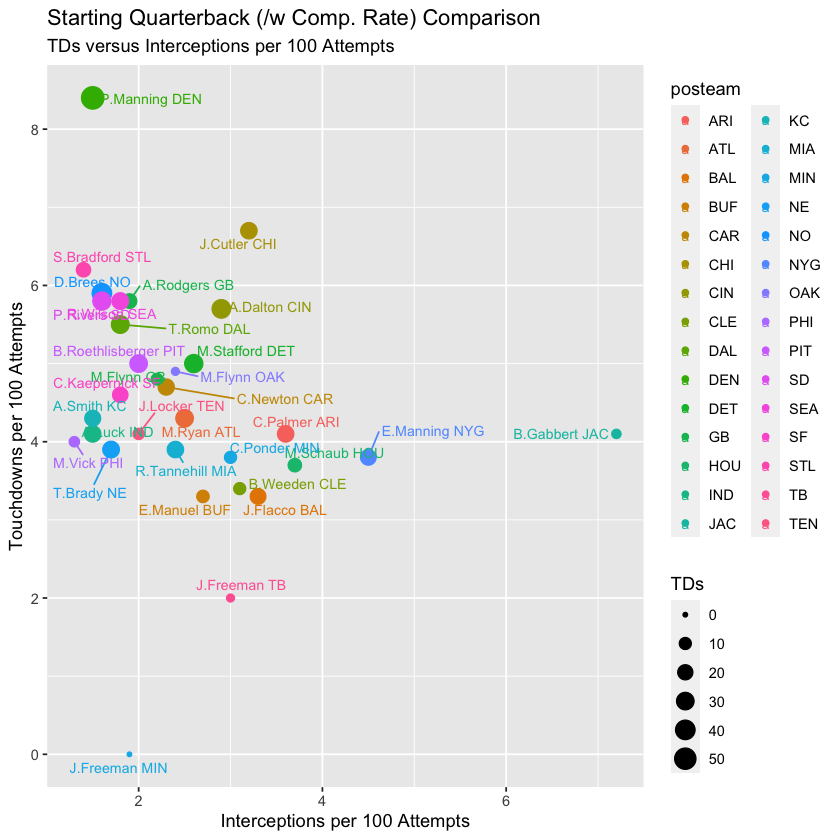

In [6]:
set.seed(42)

ggplot(QB.Rating, aes(y = TDs.per.att, x = Interceptions.per.att, color = posteam, size = TDs)) +
geom_point()+ geom_text_repel(aes(label = QB.team), size = 3) + 
labs(title="Starting Quarterback (/w Comp. Rate) Comparison", 
     subtitle="TDs versus Interceptions per 100 Attempts",x = "Interceptions per 100 Attempts", 
     y="Touchdowns per 100 Attempts") 


TDs versus INTs per 100 Attempts helps us analyze the risk/reqrd of quartberback decision making, the size of the points indicates the number of TD thrown. We see that teams like Denver, Seattle and New Orleans all have a good TD to INT ratio. All of them led their teams into the playoffs. Thus, we can deduce that higher QB ratings translates into more winning for teams

In [7]:
coef(lm(Total.Yards ~ TDs, data = QB.Rating))

(Intercept)         TDs 
   456.7865    109.5904

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”


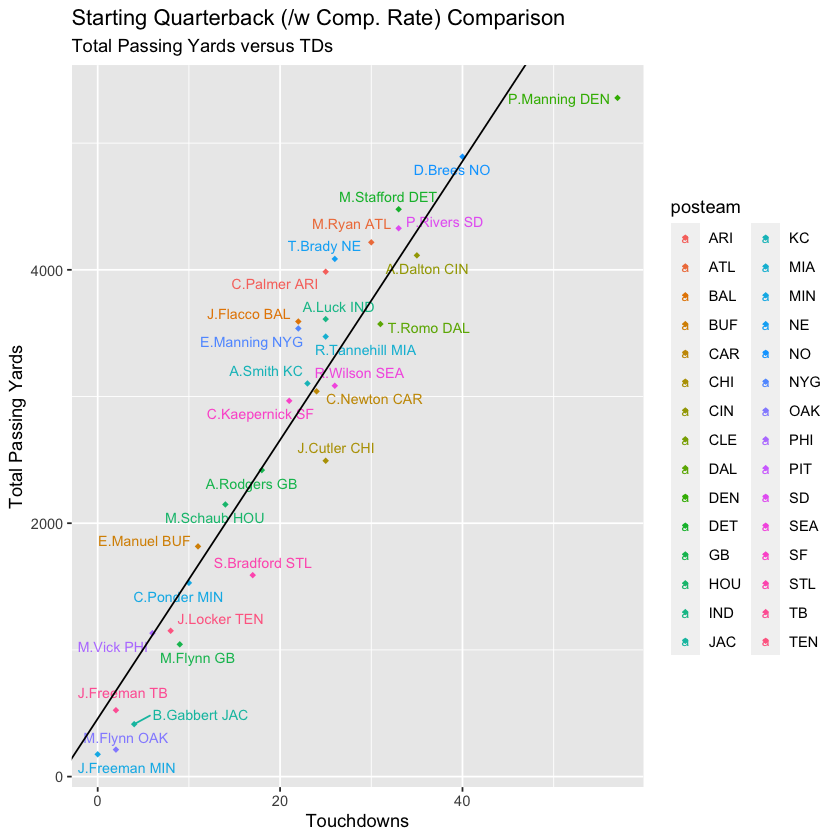

In [8]:
ggplot(QB.Rating, aes(y=Total.Yards,x=TDs,color=posteam))+
geom_point(shape=18)+
geom_text_repel(aes(label = paste(QB.team)), size = 3) +
  geom_abline(slope=110,intercept=457)+
  labs(title="Starting Quarterback (/w Comp. Rate) Comparison", 
       subtitle="Total Passing Yards versus TDs",x="Touchdowns", y="Total Passing Yards")


Quarterbacks under the abline tend to score more touchdowns in relations to the total yards and vice versa. 

### SubQuestion 2: Do Rushing Quaterbacks Have a Greater Impact on Team Winning?
Among the starting NFL Quarterbacks, I want to analyze the success rate of them running and how that translates into points scored. A mobile/agile quarterback is often viewed as a desirable trait to possess for the position, however, creating a chart and some plots will help us better understand the relationship between rushing ability and team success.

#### Identifying Running Quarterbacks
Here I am going to use to plays data set to extract all the starting quarterbacks who rushed the football. The table generated gives us an interesting visual with many statistics related to running the football

In [9]:
QB.Rusher = plays %>%
  filter(play_type == "run") %>%
  mutate(QB.team = paste(rusher_player_name, posteam, sep=" ")) %>%
  group_by(QB.team, posteam) %>%
  summarise(Games.Played = n_distinct(game_date),
                Total.Runs = n(),
                Total.Yards = sum(yards_gained),
                Fumbles = sum(fumble),
                Runs.per.Game = Total.Runs/Games.Played,
                Fumbles.per.Yard = round(Fumbles/Total.Yards*100,3),
                Yards.per.Att = sum(yards_gained)/Total.Runs,
                TDs = sum(touchdown),
                TDs.per.100 = round(TDs/Total.Runs,3)*100) %>%
  filter(QB.team %in% starters_team) %>%
  arrange(posteam)

QB.Rusher

`summarise()` has grouped output by 'QB.team'. You can override using the `.groups` argument.



QB.team,posteam,Games.Played,Total.Runs,Total.Yards,Fumbles,Runs.per.Game,Fumbles.per.Yard,Yards.per.Att,TDs,TDs.per.100
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C.Palmer ARI,ARI,5,7,23,1,1.400000,4.348,3.285714,0,0.0
M.Ryan ATL,ATL,7,10,71,2,1.428571,2.817,7.100000,0,0.0
J.Flacco BAL,BAL,12,19,138,0,1.583333,0.000,7.263158,1,5.3
E.Manuel BUF,BUF,10,41,212,3,4.100000,1.415,5.170732,2,4.9
C.Newton CAR,CAR,16,100,602,2,6.250000,0.332,6.020000,6,6.0
J.Cutler CHI,CHI,8,15,124,1,1.875000,0.806,8.266667,0,0.0
A.Dalton CIN,CIN,15,43,196,1,2.866667,0.510,4.558140,2,4.7
B.Weeden CLE,CLE,6,10,NA,1,1.666667,NA,NA,0,0.0
T.Romo DAL,DAL,8,11,47,2,1.375000,4.255,4.272727,0,0.0


In the above table we can see the rushing stats of all the quarterbacks which gives us some really useful data. However, there are only 31 observations. That means one quarterback never even attempted a rush. Lets find out who that was.

In [10]:
starters_team[!starters_team %in%QB.Rusher$QB.team]

[1] "J.Freeman MIN"

##### Starting QB Rushing Plot
Now we can create a scatterplot of the starting QB rushing statistics and how that translates into touchdowns for their team. We can accomplish this by using ggplot

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


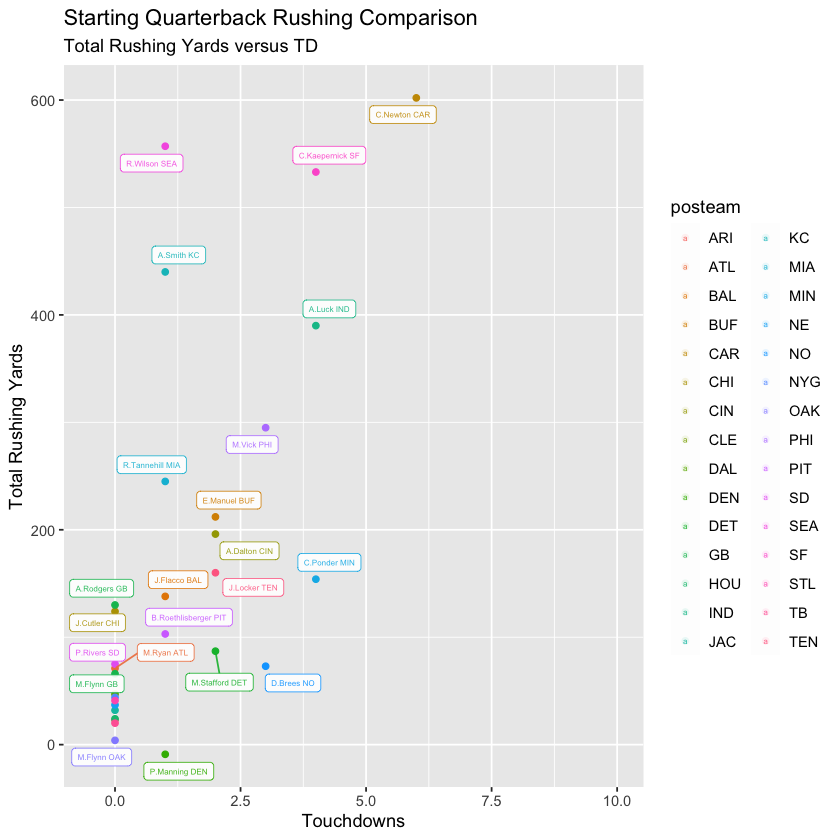

In [11]:
ggplot(QB.Rusher, aes(y=Total.Yards,x=TDs, color=posteam)) +
geom_point()+ geom_label_repel(aes(label = QB.team),size = 1.7,alpha=0.9) + 
scale_x_continuous(limits = c(-0.5, 10))+ labs(title="Starting Quarterback Rushing Comparison", 
subtitle="Total Rushing Yards versus TD",x="Touchdowns", y= "Total Rushing Yards")

Cam Newton was clearly the best rushing quarterback during the season as he had a very high number of total rushing yards which also translated to more touchdowns scored. This is interesting to note because Carloina made it to the second round of the playoffs which is difficult to do. Similarly, Russel Wilson and Colin Kaepernick also have a high number of rush yards and their respective teams met in the NFC Championship that year. Thus, it would be a reasonable statement to say that more mobile quarterbacks (quarterbacks that can run the ball) help lead their teams to more wins!

##### Fumbling and its effect
Fumbles are a huge part of the game of football. They can cause momentum shifts and cause game altering moments that dictate who wins a game. As a quarterback, fumbles are your worst nightmare and impact your team negatively. Here, my goal is to use ggplot to create a scatterplot of the quarterbacks who rushed the ball and analyze their rush yards along with the fumbles they lost. This is a good indicator of whether a quarterback is capable of running effectively and if they should continue, or rather stick to throwing the ball. Finally, we only want to look at QB's who ran the ball over 2 times per game as that shows a tendency in their game rather than running by chance

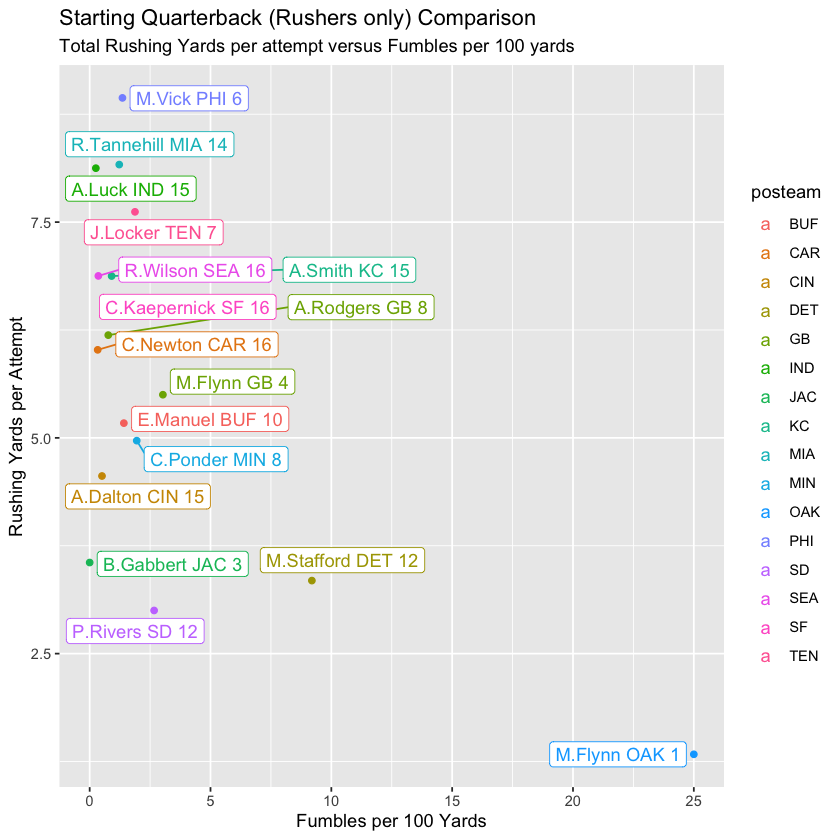

In [12]:
QB.Rusher2 = subset(QB.Rusher,Runs.per.Game > 2)

ggplot(subset(QB.Rusher, Runs.per.Game > 2), aes(y=Yards.per.Att,x=Fumbles.per.Yard,color=posteam))+
geom_point()+ 
geom_label_repel(aes(label = paste(QB.team, Games.Played)))+
  labs(title="Starting Quarterback (Rushers only) Comparison", 
       subtitle="Total Rushing Yards per attempt versus Fumbles per 100 yards",
       x="Fumbles per 100 Yards", y="Rushing Yards per Attempt")

We can see that Matt Flynn has many fumbles given his rushing attempts. This is indicative that he is not a good rusher and that its impacting his team's ability to win as Oakland did not make the playoffs that year.

### Conclusion
After performing all the data analyis above, we can see that rushing quarterbacks have an advantage over solely pocket passing quarterbacks as they add an additional dimension to the offense and create more opportunities for their team. This is indicative because successful rushing quarterbacks which we have identified from abive such as Seattle's Russell Wilson, Carolina's Cam Newton, and San Francisco's Colin Kaepernick all led their teams deep into the postseason that year. Additionally, although these quarterbacks may have slightly lower QB Ratings (which we calculated in the first part) in comparison to the rest of the league, this is because rushing the football involves higher risk as a quarterback. Since QB Rating is a holistic measure of a quarterback's performance, the statistics may be negatively impacted by running the ball, however, overall we see that this leads to increased team success.